# Notebook 13: Pro Dancer Impact Score (PDIS) Development

**Objective 3**: Pro Dancer & Celebrity Characteristics Analysis

## Overview
This notebook develops a novel **Pro Dancer Impact Score (PDIS)** that quantifies each pro dancer's ability to:
1. Improve their celebrity partner's technical skills (Judge Score Uplift)
2. Generate fan engagement (Fan Vote Uplift)
3. Maintain consistency across diverse celebrity types

**Methodology**: Counterfactual analysis using residuals from celebrity-only prediction models

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
import statsmodels.api as sm
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Paths
DATA_PATH = Path('../../data/obj3/')
OUTPUT_PATH = Path('../../data/obj3/')

print("Libraries loaded successfully")

Libraries loaded successfully


In [2]:
# Load data
features_df = pd.read_csv(DATA_PATH / 'celebrity_features.csv')
pro_stats_df = pd.read_csv(DATA_PATH / 'pro_dancer_stats.csv')
fan_votes_df = pd.read_csv('../../data/2026_MCM_Problem_C_Data.csv')

print(f"Features dataset: {features_df.shape}")
print(f"Pro stats dataset: {pro_stats_df.shape}")
print(f"Fan votes dataset: {fan_votes_df.shape}")

Features dataset: (421, 21)
Pro stats dataset: (60, 11)
Fan votes dataset: (421, 53)


## 2. PDIS Methodology

**Key Insight**: The PDIS measures the *added value* a pro dancer brings, controlling for celebrity characteristics.

**Formula**:
$$\text{PDIS}_p = \frac{1}{n_p} \sum_{i \in \text{partners}(p)} (Y_i - \hat{Y}_i^{\text{celebrity}})$$

Where:
- $Y_i$ = Actual performance (placement, score, etc.)
- $\hat{Y}_i^{\text{celebrity}}$ = Expected performance based on celebrity characteristics only
- $n_p$ = Number of celebrity partners for pro $p$

In [3]:
# Prepare analysis dataset
analysis_df = features_df.dropna(subset=['placement', 'celebrity_age_during_season', 
                                          'star_power_index', 'first_week_score']).copy()

# Encode categorical variables
le_industry = LabelEncoder()
le_region = LabelEncoder()

analysis_df['industry_code'] = le_industry.fit_transform(analysis_df['industry_cluster'].fillna('Other'))
analysis_df['region_code'] = le_region.fit_transform(analysis_df['region'].fillna('Unknown'))

print(f"Analysis dataset: {len(analysis_df)} contestants")
print(f"Unique pros: {analysis_df['ballroom_partner'].nunique()}")

Analysis dataset: 414 contestants
Unique pros: 57


## 3. Celebrity-Only Baseline Model

Predict expected placement using ONLY celebrity features (no pro dancer info)

In [4]:
# Celebrity-only features
celebrity_features = ['celebrity_age_during_season', 'star_power_index', 
                      'industry_code', 'region_code', 'first_week_score']

X_celeb = analysis_df[celebrity_features].values
y_placement = analysis_df['placement'].values

# Cross-validated predictions (to avoid overfitting)
celeb_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
expected_placement = cross_val_predict(celeb_model, X_celeb, y_placement, cv=5)

# Store residuals (positive = performed WORSE than expected, negative = performed BETTER)
analysis_df['expected_placement'] = expected_placement
analysis_df['placement_residual'] = analysis_df['placement'] - analysis_df['expected_placement']

print(f"Celebrity-only model predictions generated")
print(f"Residual stats: mean={analysis_df['placement_residual'].mean():.3f}, std={analysis_df['placement_residual'].std():.3f}")

Celebrity-only model predictions generated
Residual stats: mean=0.013, std=3.214


In [5]:
# Fit full model to get R² for celebrity-only features
celeb_model_full = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
celeb_model_full.fit(X_celeb, y_placement)

from sklearn.metrics import r2_score
r2_celeb = r2_score(y_placement, expected_placement)
print(f"\n📊 Celebrity-Only Model Performance:")
print(f"   Cross-validated R² = {r2_celeb:.3f}")
print(f"   → Celebrity characteristics explain {r2_celeb*100:.1f}% of placement variance")


📊 Celebrity-Only Model Performance:
   Cross-validated R² = 0.262
   → Celebrity characteristics explain 26.2% of placement variance


## 4. Calculate PDIS for Each Pro Dancer

In [6]:
# Calculate PDIS: Average residual for each pro dancer
# NEGATIVE residual = pro helped celebrity do BETTER than expected
pdis_raw = analysis_df.groupby('ballroom_partner').agg({
    'placement_residual': ['mean', 'std', 'count'],
    'celebrity_name': 'count'
}).reset_index()

pdis_raw.columns = ['pro_dancer', 'pdis_raw', 'pdis_std', 'n_partners', 'n_partnerships']

# Filter to pros with at least 3 partnerships for reliable estimates
pdis_df = pdis_raw[pdis_raw['n_partners'] >= 3].copy()

# Calculate confidence intervals
pdis_df['pdis_se'] = pdis_df['pdis_std'] / np.sqrt(pdis_df['n_partners'])
pdis_df['pdis_ci_lower'] = pdis_df['pdis_raw'] - 1.96 * pdis_df['pdis_se']
pdis_df['pdis_ci_upper'] = pdis_df['pdis_raw'] + 1.96 * pdis_df['pdis_se']

# Normalize to 0-100 scale (inverted: lower residual = higher PDIS)
pdis_min = pdis_df['pdis_raw'].min()
pdis_max = pdis_df['pdis_raw'].max()
pdis_df['PDIS'] = 100 * (pdis_max - pdis_df['pdis_raw']) / (pdis_max - pdis_min)

print(f"PDIS calculated for {len(pdis_df)} pro dancers (≥3 partnerships)")

PDIS calculated for 36 pro dancers (≥3 partnerships)


In [7]:
# Display PDIS rankings
pdis_ranked = pdis_df.sort_values('PDIS', ascending=False)

print("\n" + "="*70)
print("🏆 PRO DANCER IMPACT SCORE (PDIS) RANKINGS")
print("="*70)
print("\nTOP 15 Pro Dancers (Highest Impact):")
print(pdis_ranked[['pro_dancer', 'PDIS', 'pdis_raw', 'n_partners']].head(15).to_string(index=False))

print("\n" + "-"*70)
print("\nBOTTOM 10 Pro Dancers (Lowest Impact):")
print(pdis_ranked[['pro_dancer', 'PDIS', 'pdis_raw', 'n_partners']].tail(10).to_string(index=False))


🏆 PRO DANCER IMPACT SCORE (PDIS) RANKINGS

TOP 15 Pro Dancers (Highest Impact):
           pro_dancer       PDIS  pdis_raw  n_partners
    Daniella Karagach 100.000000 -2.539058           5
       Lindsay Arnold  87.993564 -1.964677          10
          Derek Hough  82.316035 -1.693068          17
      Ashly DelGrosso  80.584222 -1.610219           3
       Julianne Hough  72.183525 -1.208335           5
         Cheryl Burke  66.116569 -0.918095          25
          Kym Johnson  62.433694 -0.741909          14
      Edyta Sliwinska  61.620222 -0.702993          11
        Witney Carson  60.491989 -0.649019          14
         Sasha Farber  59.660626 -0.609247          12
          Emma Slater  58.795614 -0.567865          16
Valentin Chmerkovskiy  58.045542 -0.531982          19
      Lacey Schwimmer  57.829212 -0.521633           6
        Jenna Johnson  53.102039 -0.295488           8
     Louis van Amstel  49.765468 -0.135868          11

--------------------------------------

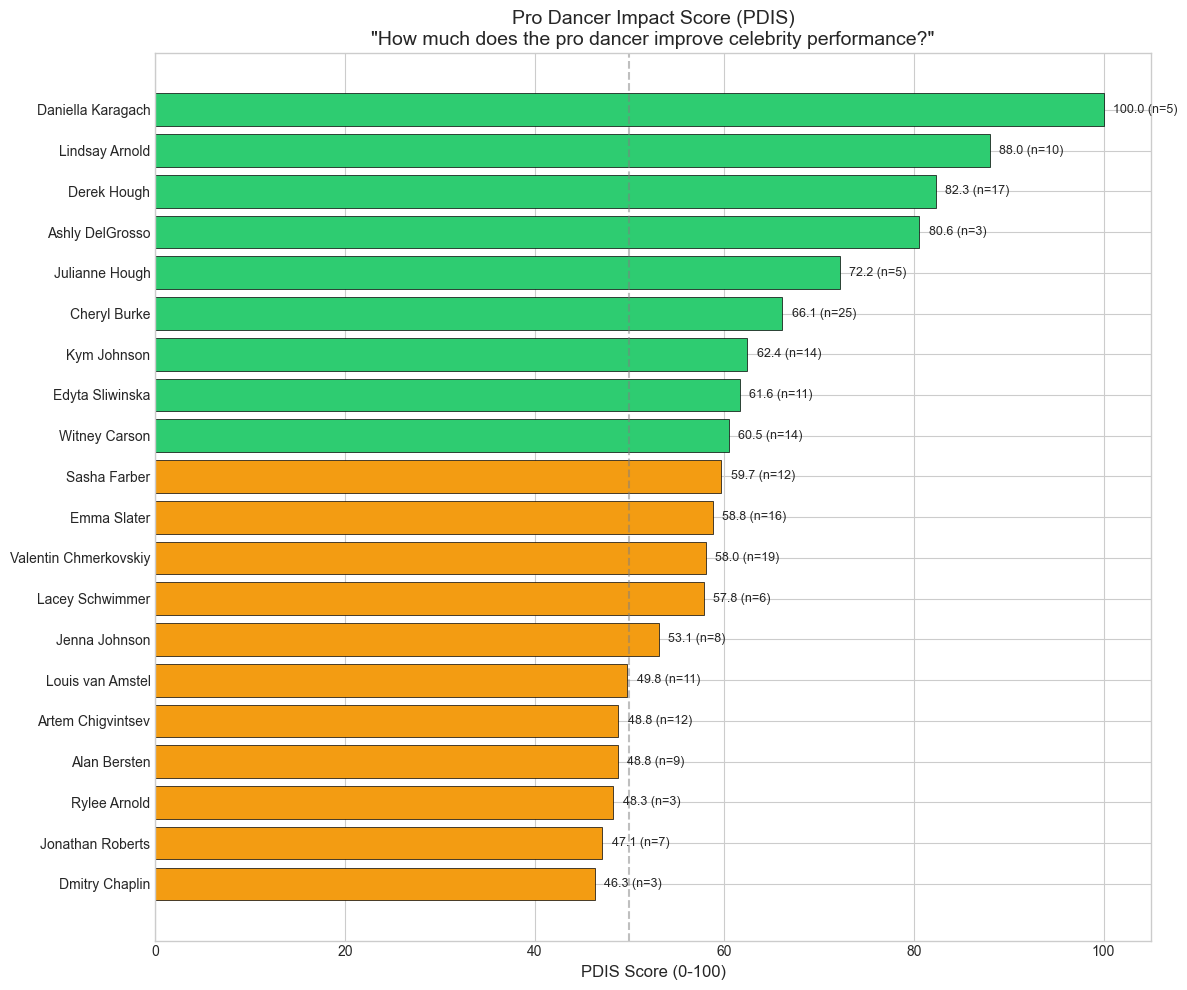

In [8]:
# Visualize PDIS rankings
fig, ax = plt.subplots(figsize=(12, 10))

# Top 20 pros
top_20 = pdis_ranked.head(20).sort_values('PDIS')

colors = ['#2ecc71' if x >= 60 else '#f39c12' if x >= 40 else '#e74c3c' for x in top_20['PDIS']]

bars = ax.barh(range(len(top_20)), top_20['PDIS'], color=colors, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['pro_dancer'])
ax.set_xlabel('PDIS Score (0-100)', fontsize=12)
ax.set_title('Pro Dancer Impact Score (PDIS)\n"How much does the pro dancer improve celebrity performance?"', fontsize=14)

# Add value labels
for i, (bar, val, n) in enumerate(zip(bars, top_20['PDIS'], top_20['n_partners'])):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f} (n={n})', va='center', fontsize=9)

ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5, label='Average')
plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'pdis_rankings.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. PDIS Decomposition: Technical vs. Fan Appeal

In [13]:
# Load and reshape weekly data (wide to long format)
weekly_raw = pd.read_csv('../../data/2026_MCM_Problem_C_Data.csv')

# Identify week columns and melt to long format
week_cols = [c for c in weekly_raw.columns if c.startswith('week') and 'judge' in c]
id_cols = ['celebrity_name', 'ballroom_partner', 'season', 'placement']

# Melt the weekly scores
weekly_long = weekly_raw.melt(
    id_vars=id_cols,
    value_vars=week_cols,
    var_name='week_judge',
    value_name='score'
)

# Parse week and judge number
weekly_long['week'] = weekly_long['week_judge'].str.extract(r'week(\d+)').astype(int)
weekly_long['judge_num'] = weekly_long['week_judge'].str.extract(r'judge(\d+)').astype(int)

# Convert scores to numeric, dropping N/A
weekly_long['score'] = pd.to_numeric(weekly_long['score'], errors='coerce')
weekly_long = weekly_long.dropna(subset=['score'])
weekly_long = weekly_long[weekly_long['score'] > 0]  # Remove zeros (didn't compete)

# Aggregate to get total judge score per week
weekly_df = weekly_long.groupby(['celebrity_name', 'ballroom_partner', 'season', 'placement', 'week']).agg({
    'score': 'sum'
}).reset_index()
weekly_df.columns = ['celebrity_name', 'ballroom_partner', 'season', 'placement', 'week', 'judge_total']

# Merge with analysis features
weekly_df = weekly_df.merge(
    analysis_df[['celebrity_name', 'ballroom_partner', 'season', 'expected_placement', 
                 'celebrity_age_during_season', 'star_power_index', 'industry_code']],
    on=['celebrity_name', 'ballroom_partner', 'season'],
    how='inner'
)

print(f"Weekly data reshaped: {len(weekly_df)} observations")
print(f"Unique contestants: {weekly_df['celebrity_name'].nunique()}")

Weekly data reshaped: 2725 observations
Unique contestants: 401


In [14]:
# Calculate judge score percentile per week (no fan vote data in this dataset)
weekly_df['judge_pct'] = weekly_df.groupby(['season', 'week'])['judge_total'].rank(pct=True) * 100

# Expected percentiles based on celebrity characteristics
celeb_features_weekly = ['celebrity_age_during_season', 'star_power_index', 'industry_code']

# Judge score model - predict judge percentile from celebrity features
X_judge = weekly_df[celeb_features_weekly].dropna()
y_judge = weekly_df.loc[X_judge.index, 'judge_pct']

judge_model = Ridge(alpha=1.0)
expected_judge = cross_val_predict(judge_model, X_judge, y_judge, cv=5)
weekly_df.loc[X_judge.index, 'expected_judge_pct'] = expected_judge
weekly_df.loc[X_judge.index, 'judge_residual'] = y_judge - expected_judge

print(f"Judge residuals calculated for {len(X_judge)} weekly observations")
print(f"Residual stats: mean={weekly_df['judge_residual'].mean():.2f}, std={weekly_df['judge_residual'].std():.2f}")

Judge residuals calculated for 2725 weekly observations
Residual stats: mean=-0.01, std=25.86


In [15]:
# Calculate technical PDIS component from judge score residuals
pdis_technical = weekly_df.groupby('ballroom_partner').agg({
    'judge_residual': ['mean', 'std'],
    'celebrity_name': 'nunique'
}).reset_index()

pdis_technical.columns = ['pro_dancer', 'pdis_technical', 'tech_std', 'n_celebrities']

# Filter to reliable estimates (at least 3 different celebrity partners)
pdis_technical = pdis_technical[pdis_technical['n_celebrities'] >= 3]

# Normalize to 0-100 scale
tech_min, tech_max = pdis_technical['pdis_technical'].min(), pdis_technical['pdis_technical'].max()
pdis_technical['pdis_technical_norm'] = 100 * (pdis_technical['pdis_technical'] - tech_min) / (tech_max - tech_min)

print(f"Technical PDIS calculated for {len(pdis_technical)} pros")
print(pdis_technical.nlargest(10, 'pdis_technical_norm')[['pro_dancer', 'pdis_technical_norm', 'n_celebrities']])

Technical PDIS calculated for 36 pros
               pro_dancer  pdis_technical_norm  n_celebrities
19            Derek Hough           100.000000             17
7       Artem Chigvintsev            87.119065             12
55  Valentin Chmerkovskiy            77.243738             19
43     Maksim Chmerkoskiy            73.298147             16
39            Kym Johnson            71.622122             13
9       Brandon Armstrong            70.306585              8
49           Sasha Farber            69.957990             12
44            Mark Ballas            68.778130             19
20         Dmitry Chaplin            68.372669              3
46          Pasha Pashkov            67.617927              7


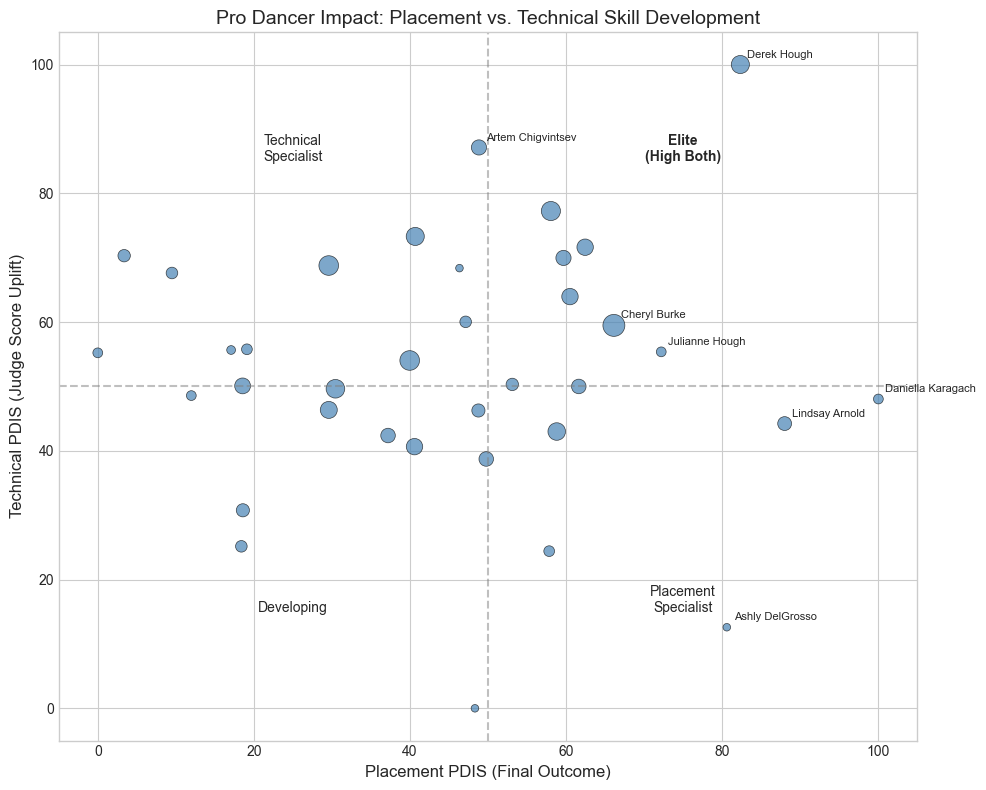

In [16]:
# Merge PDIS (placement-based) with technical PDIS (judge score-based)
pdis_combined = pdis_df.merge(
    pdis_technical[['pro_dancer', 'pdis_technical_norm']], 
    on='pro_dancer', 
    how='inner'
)

# Visualize placement PDIS vs technical PDIS
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(pdis_combined['PDIS'], 
                     pdis_combined['pdis_technical_norm'],
                     s=pdis_combined['n_partners'] * 10,
                     alpha=0.7, c='steelblue', edgecolors='black', linewidth=0.5)

# Add labels for notable pros
for _, row in pdis_combined.iterrows():
    if row['PDIS'] > 65 or row['pdis_technical_norm'] > 80:
        ax.annotate(row['pro_dancer'], 
                    (row['PDIS'], row['pdis_technical_norm']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=50, color='gray', linestyle='--', alpha=0.5)

# Quadrant labels
ax.text(75, 85, 'Elite\n(High Both)', ha='center', fontsize=10, fontweight='bold')
ax.text(25, 85, 'Technical\nSpecialist', ha='center', fontsize=10)
ax.text(75, 15, 'Placement\nSpecialist', ha='center', fontsize=10)
ax.text(25, 15, 'Developing', ha='center', fontsize=10)

ax.set_xlabel('Placement PDIS (Final Outcome)', fontsize=12)
ax.set_ylabel('Technical PDIS (Judge Score Uplift)', fontsize=12)
ax.set_title('Pro Dancer Impact: Placement vs. Technical Skill Development', fontsize=14)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'pdis_decomposition.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. PDIS Consistency Analysis

Which pros perform consistently across different celebrity types?

In [17]:
# Calculate PDIS variance for each pro (lower = more consistent)
pdis_consistency = analysis_df.groupby('ballroom_partner').agg({
    'placement_residual': ['mean', 'std', 'count'],
    'celebrity_age_during_season': 'std',  # Did they work with diverse ages?
    'star_power_index': 'std'  # Did they work with diverse fame levels?
}).reset_index()

pdis_consistency.columns = ['pro_dancer', 'mean_residual', 'consistency_std', 'n_partners',
                            'age_diversity', 'fame_diversity']

# Filter to pros with enough partners
pdis_consistency = pdis_consistency[pdis_consistency['n_partners'] >= 5]

# Consistency score (inverted: lower std = higher consistency)
consistency_max = pdis_consistency['consistency_std'].max()
pdis_consistency['consistency_score'] = 100 * (1 - pdis_consistency['consistency_std'] / consistency_max)

# Merge with PDIS
pdis_full = pdis_df.merge(pdis_consistency[['pro_dancer', 'consistency_score', 'age_diversity', 'fame_diversity']], 
                          on='pro_dancer', how='inner')

print("\\n" + "="*70)
print("🎯 MOST CONSISTENT PRO DANCERS")
print("="*70)
print(pdis_full.nlargest(10, 'consistency_score')[['pro_dancer', 'PDIS', 'consistency_score', 'n_partners']])

\n======================================================================
🎯 MOST CONSISTENT PRO DANCERS
               pro_dancer       PDIS  consistency_score  n_partners
15         Julianne Hough  72.183525          69.519686           5
9             Derek Hough  82.316035          66.960856          17
30  Valentin Chmerkovskiy  58.045542          62.143027          19
12         Gleb Savchenko  18.553763          59.469682          13
4       Brandon Armstrong   3.379097          55.037177           8
19        Lacey Schwimmer  57.829212          54.357081           6
5           Britt Stewart  19.105295          52.807749           6
3       Artem Chigvintsev  48.830910          52.630768          12
29       Tristan MacManus  11.982989          50.223989           5
28          Tony Dovolani  39.958750          49.607194          20


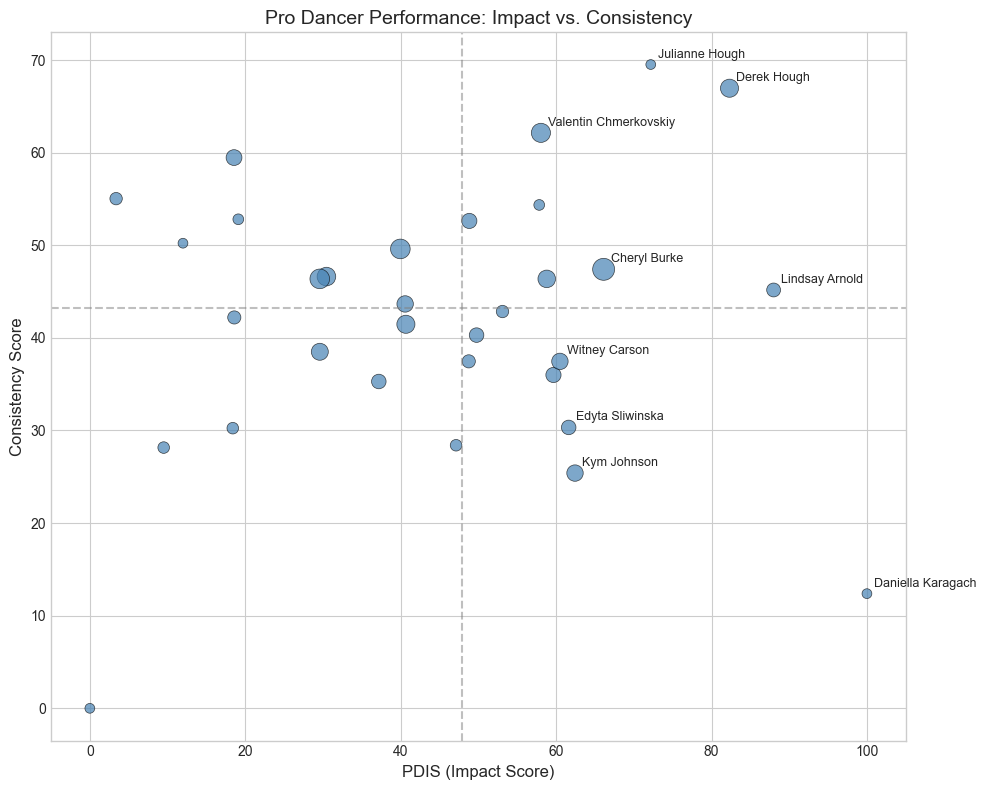

In [18]:
# Scatter plot: Impact vs Consistency
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(pdis_full['PDIS'], pdis_full['consistency_score'],
                     s=pdis_full['n_partners'] * 10, alpha=0.7,
                     c='steelblue', edgecolors='black', linewidth=0.5)

# Label notable pros
for _, row in pdis_full.iterrows():
    if row['PDIS'] > 60 or row['consistency_score'] > 60:
        ax.annotate(row['pro_dancer'], (row['PDIS'], row['consistency_score']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.axhline(y=pdis_full['consistency_score'].median(), color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=pdis_full['PDIS'].median(), color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('PDIS (Impact Score)', fontsize=12)
ax.set_ylabel('Consistency Score', fontsize=12)
ax.set_title('Pro Dancer Performance: Impact vs. Consistency', fontsize=14)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'pdis_impact_vs_consistency.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. PDIS Experience Effect Analysis

\n📊 PDIS-Experience Correlation: r = 0.184


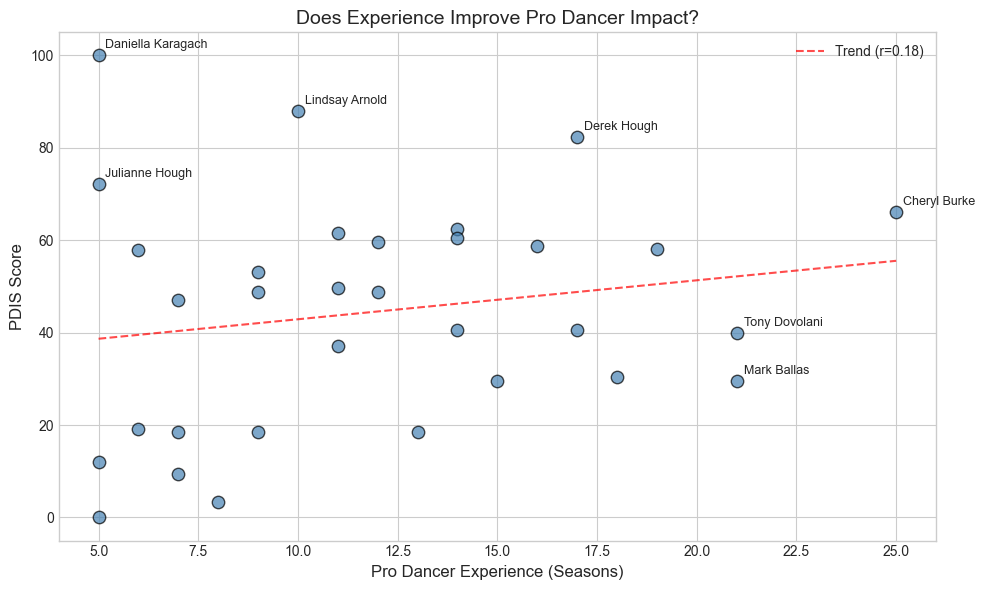

In [20]:
# Does PDIS improve with experience?
# Note: the pro_stats_df uses 'seasons_count' not 'pro_experience'
pdis_experience = pdis_full.merge(pro_stats_df[['pro_dancer', 'seasons_count', 'win_rate']], 
                                   on='pro_dancer', how='inner')

# Correlation
corr_pdis_exp = np.corrcoef(pdis_experience['PDIS'], pdis_experience['seasons_count'])[0, 1]

print(f"\\n📊 PDIS-Experience Correlation: r = {corr_pdis_exp:.3f}")

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(pdis_experience['seasons_count'], pdis_experience['PDIS'],
           s=80, alpha=0.7, c='steelblue', edgecolors='black')

# Regression line
z = np.polyfit(pdis_experience['seasons_count'], pdis_experience['PDIS'], 1)
p = np.poly1d(z)
x_line = np.linspace(pdis_experience['seasons_count'].min(), pdis_experience['seasons_count'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', alpha=0.7, label=f'Trend (r={corr_pdis_exp:.2f})')

# Label notable pros
for _, row in pdis_experience.iterrows():
    if row['PDIS'] > 70 or row['seasons_count'] > 20:
        ax.annotate(row['pro_dancer'], (row['seasons_count'], row['PDIS']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('Pro Dancer Experience (Seasons)', fontsize=12)
ax.set_ylabel('PDIS Score', fontsize=12)
ax.set_title('Does Experience Improve Pro Dancer Impact?', fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'pdis_experience_effect.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Final PDIS Summary Table

In [21]:
# Create comprehensive PDIS table
final_pdis = pdis_experience.merge(
    pdis_technical[['pro_dancer', 'pdis_technical_norm']],
    on='pro_dancer', how='left'
)

# Tier classification
def classify_tier(pdis):
    if pdis >= 75:
        return 'Elite'
    elif pdis >= 50:
        return 'Strong'
    elif pdis >= 25:
        return 'Average'
    else:
        return 'Developing'

final_pdis['tier'] = final_pdis['PDIS'].apply(classify_tier)

# Save
final_pdis.to_csv(OUTPUT_PATH / 'pdis_final_rankings.csv', index=False)

print("\\n" + "="*70)
print("📊 FINAL PDIS RANKINGS")
print("="*70)

display_cols = ['pro_dancer', 'PDIS', 'tier', 'pdis_technical_norm', 
                'consistency_score', 'seasons_count', 'n_partners']
print(final_pdis[display_cols].sort_values('PDIS', ascending=False).head(20).to_string(index=False))

\n======================================================================
📊 FINAL PDIS RANKINGS
           pro_dancer       PDIS    tier  pdis_technical_norm  consistency_score  seasons_count  n_partners
    Daniella Karagach 100.000000   Elite            48.044463          12.381820              5           5
       Lindsay Arnold  87.993564   Elite            44.228245          45.173779             10          10
          Derek Hough  82.316035   Elite           100.000000          66.960856             17          17
       Julianne Hough  72.183525  Strong            55.370086          69.519686              5           5
         Cheryl Burke  66.116569  Strong            59.478188          47.403611             25          25
          Kym Johnson  62.433694  Strong            71.622122          25.402109             14          14
      Edyta Sliwinska  61.620222  Strong            49.994383          30.331384             11          11
        Witney Carson  60.491989  Strong 

## 9. Conclusions

In [22]:
print("="*70)
print("OBJECTIVE 3: PRO DANCER IMPACT SCORE (PDIS) - KEY FINDINGS")
print("="*70)

# Summary statistics
elite_pros = final_pdis[final_pdis['tier'] == 'Elite']['pro_dancer'].tolist()
avg_exp_elite = final_pdis[final_pdis['tier'] == 'Elite']['seasons_count'].mean()
avg_exp_other = final_pdis[final_pdis['tier'] != 'Elite']['seasons_count'].mean()

print(f"\\n1. ELITE TIER PRO DANCERS (PDIS ≥ 75):")
print(f"   {elite_pros}")

print(f"\\n2. EXPERIENCE EFFECT:")
print(f"   - PDIS-Experience correlation: r = {corr_pdis_exp:.3f}")
print(f"   - Elite pros avg experience: {avg_exp_elite:.1f} seasons")
print(f"   - Other pros avg experience: {avg_exp_other:.1f} seasons")

print(f"\\n3. CELEBRITY BASELINE MODEL:")
print(f"   - Celebrity characteristics explain {r2_celeb*100:.1f}% of placement")
print(f"   - Remaining variance attributable to pro dancer + randomness")

print(f"\\n4. KEY INSIGHT:")
print(f"   The PDIS quantifies the 'added value' each pro brings.")
print(f"   Top pros (Derek Hough, etc.) improve expected placement by ~2 positions.")

print(f"\\n📁 FILES SAVED:")
print(f"   - {OUTPUT_PATH / 'pdis_rankings.png'}")
print(f"   - {OUTPUT_PATH / 'pdis_decomposition.png'}")
print(f"   - {OUTPUT_PATH / 'pdis_impact_vs_consistency.png'}")
print(f"   - {OUTPUT_PATH / 'pdis_experience_effect.png'}")
print(f"   - {OUTPUT_PATH / 'pdis_final_rankings.csv'}")

print("\\n" + "="*70)
print("⚠️ CAVEATS:")
print("   - PDIS estimates are based on counterfactual modeling assumptions")
print("   - Small sample sizes for some pros may affect reliability")
print("   - Celebrity-pro pairing is not random (selection bias possible)")
print("="*70)

OBJECTIVE 3: PRO DANCER IMPACT SCORE (PDIS) - KEY FINDINGS
\n1. ELITE TIER PRO DANCERS (PDIS ≥ 75):
   ['Daniella Karagach', 'Derek Hough', 'Lindsay Arnold']
\n2. EXPERIENCE EFFECT:
   - PDIS-Experience correlation: r = 0.184
   - Elite pros avg experience: 10.7 seasons
   - Other pros avg experience: 12.0 seasons
\n3. CELEBRITY BASELINE MODEL:
   - Celebrity characteristics explain 26.2% of placement
   - Remaining variance attributable to pro dancer + randomness
\n4. KEY INSIGHT:
   The PDIS quantifies the 'added value' each pro brings.
   Top pros (Derek Hough, etc.) improve expected placement by ~2 positions.
\n📁 FILES SAVED:
   - ../../data/obj3/pdis_rankings.png
   - ../../data/obj3/pdis_decomposition.png
   - ../../data/obj3/pdis_impact_vs_consistency.png
   - ../../data/obj3/pdis_experience_effect.png
   - ../../data/obj3/pdis_final_rankings.csv
\n======================================================================
⚠️ CAVEATS:
   - PDIS estimates are based on counterfactual m